# Simulation studies using Hastie's data

The goal of this simulation study is to see how the performance of the Bayesian-encoded model varies for different values of the hyperparameters. 


In [1]:
%load_ext autoreload
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys,os, pathlib
current = pathlib.Path(os.getcwd())
base = current.parent.parent
catenc = base.joinpath('categorical-encoding')
sys.path.append(str(catenc))

# Binary classification problem

For Binary classifier we will work with the example 10.2 of T. Hastie, R. Tibshirani and J. Friedman, "Elements of Statistical Learning Ed. 2", Springer, 2009.

In [3]:
from sklearn.datasets import make_hastie_10_2
X_h, y_h = make_hastie_10_2(random_state=2834)
X_h = X_h.astype('float16')
y_h[y_h==-1]=0

In [4]:
#Now convert the last column to the categorical
from sklearn.preprocessing import KBinsDiscretizer
disczr1 = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
cat_column1 = disczr1.fit_transform(X_h[:,-1].reshape(-1, 1)) * 193 % 20 #We want to break the monotonicity
disczr2 = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='uniform')
cat_column2 = disczr2.fit_transform(X_h[:,-2].reshape(-1, 1)) * 173 % 20 #We want to break the monotonicity

In [5]:
predictors = pd.DataFrame(X_h[:, 0:-2], columns=[f'col_{i}' for i in range(8)])
predictors['cat1'] = cat_column1
predictors['cat2'] = cat_column2
#predictors['cat1_orig'] = cat_column1
#predictors['cat2_orig'] = cat_column2
predictors.head(3)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,cat1,cat2
0,-1.373047,-2.091797,1.708984,-0.275146,-0.398926,1.024414,-0.765137,-0.189331,4.0,11.0
1,0.469238,1.482422,0.573730,1.517578,-0.036804,-0.188110,-0.654785,1.072266,17.0,18.0
2,-0.405518,0.231201,-1.037109,-0.901855,-2.525391,0.429199,-1.176758,-0.426025,17.0,11.0


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
model = RandomForestClassifier(n_estimators=400, max_depth=40, random_state=2834, n_jobs=-1) 
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:,1]

print('Train accuracy: ', accuracy_score(y_train, model.predict(X_train)))
print('Test accuracy: ', accuracy_score(y_test, preds.round()))
print('AUC: ', roc_auc_score(y_test, preds).round(4))

Train accuracy:  1.0
Test accuracy:  0.84875
AUC:  0.9255


Hyperparameter tuning: optimizing for AUC
estimators: 400
max depth:
* 15 | 0.9334 
* 17 | 0.9384
* 19 | 0.9398
* 21 | 0.9415
* 25 | 0.9449
* 30 | 0.947
* 10 | 0.9476

## Cross-validation

We really should use cross-validation to avoid overfitting

### Cross-validation of the target encoding model

First we will train a model using target encoding

In [25]:
%%time
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from category_encoders.leave_one_out import LeaveOneOutEncoder
import optuna
from optuna.distributions import *

loo = LeaveOneOutEncoder(cols=['cat1', 'cat2'], sigma=0.05, random_state=2834)
rf = RandomForestClassifier(n_estimators=400, max_depth=30, max_features=1, min_samples_leaf=1,
                            random_state=2834, n_jobs=-1) 
pipe = Pipeline(steps=[('loo',loo), ('rf',rf)])

param_distribution = {
    'loo__sigma': LogUniformDistribution(1E-5, 1E-1),
    'rf__max_depth': IntUniformDistribution(5,40),
    'rf__max_features' : IntUniformDistribution(1,10),
    'rf__min_samples_leaf': IntUniformDistribution(1,10)
}

X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)
search = optuna.integration.OptunaSearchCV(pipe, param_distribution, 
                    cv=5, n_jobs=-1, random_state=514, n_trials=None, timeout= 20*60, scoring='accuracy')
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
test_predict = search.best_estimator_.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test, test_predict))

[I 2020-05-15 18:25:20,698] Finished trial#3 with value: 0.7517708333333333 with parameters: {'loo__sigma': 1.1404293223371326e-05, 'rf__max_depth': 6, 'rf__max_features': 1, 'rf__min_samples_leaf': 8}. Best is trial#3 with value: 0.7517708333333333.
[I 2020-05-15 18:25:21,804] Finished trial#5 with value: 0.5525 with parameters: {'loo__sigma': 1.1755777640624622e-05, 'rf__max_depth': 20, 'rf__max_features': 7, 'rf__min_samples_leaf': 3}. Best is trial#3 with value: 0.7517708333333333.
[I 2020-05-15 18:25:21,979] Finished trial#0 with value: 0.8363541666666666 with parameters: {'loo__sigma': 0.006693641748475297, 'rf__max_depth': 8, 'rf__max_features': 2, 'rf__min_samples_leaf': 3}. Best is trial#0 with value: 0.8363541666666666.
[I 2020-05-15 18:25:22,835] Finished trial#9 with value: 0.5701041666666666 with parameters: {'loo__sigma': 0.00011942439775362347, 'rf__max_depth': 27, 'rf__max_features': 9, 'rf__min_samples_leaf': 3}. Best is trial#0 with value: 0.8363541666666666.
[I 2020-

[I 2020-05-15 18:30:02,635] Finished trial#32 with value: 0.8846875000000001 with parameters: {'loo__sigma': 0.0008226368350579373, 'rf__max_depth': 35, 'rf__max_features': 1, 'rf__min_samples_leaf': 10}. Best is trial#10 with value: 0.8939583333333332.
[I 2020-05-15 18:30:11,732] Finished trial#33 with value: 0.8922916666666667 with parameters: {'loo__sigma': 0.0011566125692304744, 'rf__max_depth': 33, 'rf__max_features': 1, 'rf__min_samples_leaf': 4}. Best is trial#10 with value: 0.8939583333333332.
[I 2020-05-15 18:30:16,033] Finished trial#34 with value: 0.8930208333333333 with parameters: {'loo__sigma': 0.02380484450585067, 'rf__max_depth': 33, 'rf__max_features': 1, 'rf__min_samples_leaf': 4}. Best is trial#10 with value: 0.8939583333333332.
[I 2020-05-15 18:30:25,076] Finished trial#35 with value: 0.8404166666666667 with parameters: {'loo__sigma': 0.00020272135322507872, 'rf__max_depth': 23, 'rf__max_features': 1, 'rf__min_samples_leaf': 4}. Best is trial#10 with value: 0.893958

[I 2020-05-15 18:36:16,720] Finished trial#65 with value: 0.8632291666666665 with parameters: {'loo__sigma': 0.001783404459574755, 'rf__max_depth': 21, 'rf__max_features': 4, 'rf__min_samples_leaf': 3}. Best is trial#36 with value: 0.8943749999999999.
[I 2020-05-15 18:36:16,889] Finished trial#66 with value: 0.8721875000000001 with parameters: {'loo__sigma': 0.0020766721036475652, 'rf__max_depth': 20, 'rf__max_features': 3, 'rf__min_samples_leaf': 3}. Best is trial#36 with value: 0.8943749999999999.
[I 2020-05-15 18:36:17,427] Finished trial#64 with value: 0.8661458333333334 with parameters: {'loo__sigma': 0.0020872888457059507, 'rf__max_depth': 20, 'rf__max_features': 4, 'rf__min_samples_leaf': 3}. Best is trial#36 with value: 0.8943749999999999.
[I 2020-05-15 18:36:29,927] Finished trial#67 with value: 0.8711458333333333 with parameters: {'loo__sigma': 0.0017731302800484603, 'rf__max_depth': 38, 'rf__max_features': 3, 'rf__min_samples_leaf': 3}. Best is trial#36 with value: 0.8943749

[I 2020-05-15 18:42:17,969] Finished trial#96 with value: 0.8984375 with parameters: {'loo__sigma': 0.010525556290483363, 'rf__max_depth': 24, 'rf__max_features': 1, 'rf__min_samples_leaf': 2}. Best is trial#82 with value: 0.8997916666666667.
[I 2020-05-15 18:42:29,423] Finished trial#97 with value: 0.8983333333333334 with parameters: {'loo__sigma': 0.0031424671854794455, 'rf__max_depth': 24, 'rf__max_features': 1, 'rf__min_samples_leaf': 2}. Best is trial#82 with value: 0.8997916666666667.
[I 2020-05-15 18:42:29,684] Finished trial#98 with value: 0.8986458333333335 with parameters: {'loo__sigma': 0.010733029524814083, 'rf__max_depth': 24, 'rf__max_features': 1, 'rf__min_samples_leaf': 2}. Best is trial#82 with value: 0.8997916666666667.
[I 2020-05-15 18:42:33,447] Finished trial#99 with value: 0.8975 with parameters: {'loo__sigma': 0.009219197961339338, 'rf__max_depth': 24, 'rf__max_features': 1, 'rf__min_samples_leaf': 2}. Best is trial#82 with value: 0.8997916666666667.
[I 2020-05-1

Best parameter (CV score=0.900):
{'loo__sigma': 0.0037110198599129706, 'rf__max_depth': 25, 'rf__max_features': 1, 'rf__min_samples_leaf': 2}
Test accuracy:  0.8958333333333334
Wall time: 21min 23s


### Cross-validation of the probabilistic encoder

First we create a class that makes it easier for us to run sklearn cross validation

In [26]:
from category_encoders.pte_utils import EncoderWrapper
from category_encoders.posterior_imputation_bc import PosteriorImputationEncoderBC

In [27]:
%%time
from sklearn.model_selection import cross_val_score

pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], random_state=2834)
model = RandomForestClassifier(n_estimators=400, random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)


param_distribution = {
    'encoder__prior_samples_ratio': LogUniformDistribution(1E-10, 1E-1),
    'encoder__n_draws': IntUniformDistribution(1,40),
    'encoder__leave_one_out': CategoricalDistribution([False, True]),
    'classifier__max_depth': IntUniformDistribution(5,40),
    'classifier__max_features' : IntUniformDistribution(1,10),
    'classifier__min_samples_leaf': IntUniformDistribution(1,10)
}


X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

search = optuna.integration.OptunaSearchCV(wrapper_model, param_distribution, 
                        cv=5, n_jobs=-1, random_state=514, n_trials=None, timeout=90*60, scoring='accuracy')

search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

test_predict = search.best_estimator_.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test, test_predict))


[I 2020-05-15 18:58:15,898] Finished trial#2 with value: 0.7058333333333333 with parameters: {'encoder__prior_samples_ratio': 0.0002369969128669313, 'encoder__n_draws': 16, 'encoder__leave_one_out': False, 'classifier__max_depth': 6, 'classifier__max_features': 10, 'classifier__min_samples_leaf': 6}. Best is trial#2 with value: 0.7058333333333333.
[I 2020-05-15 18:59:31,686] Finished trial#3 with value: 0.8501041666666668 with parameters: {'encoder__prior_samples_ratio': 0.003008351656142808, 'encoder__n_draws': 4, 'encoder__leave_one_out': True, 'classifier__max_depth': 21, 'classifier__max_features': 10, 'classifier__min_samples_leaf': 1}. Best is trial#3 with value: 0.8501041666666668.
[I 2020-05-15 19:05:42,450] Finished trial#13 with value: 0.8715624999999999 with parameters: {'encoder__prior_samples_ratio': 1.2359127489781735e-10, 'encoder__n_draws': 3, 'encoder__leave_one_out': False, 'classifier__max_depth': 26, 'classifier__max_features': 8, 'classifier__min_samples_leaf': 4}.

[I 2020-05-15 20:14:55,945] Finished trial#12 with value: 0.8662500000000002 with parameters: {'encoder__prior_samples_ratio': 1.6976140684133832e-09, 'encoder__n_draws': 35, 'encoder__leave_one_out': True, 'classifier__max_depth': 26, 'classifier__max_features': 3, 'classifier__min_samples_leaf': 5}. Best is trial#23 with value: 0.8932291666666666.
[I 2020-05-15 20:14:59,118] Finished trial#31 with value: 0.8741666666666668 with parameters: {'encoder__prior_samples_ratio': 2.1698224050203529e-10, 'encoder__n_draws': 8, 'encoder__leave_one_out': False, 'classifier__max_depth': 34, 'classifier__max_features': 4, 'classifier__min_samples_leaf': 4}. Best is trial#23 with value: 0.8932291666666666.
[I 2020-05-15 20:17:25,412] Finished trial#24 with value: 0.8928125 with parameters: {'encoder__prior_samples_ratio': 1.0459764616430934e-10, 'encoder__n_draws': 36, 'encoder__leave_one_out': False, 'classifier__max_depth': 40, 'classifier__max_features': 1, 'classifier__min_samples_leaf': 4}. B

Best parameter (CV score=0.893):
{'encoder__prior_samples_ratio': 2.649927356403324e-07, 'encoder__n_draws': 39, 'encoder__leave_one_out': False, 'classifier__max_depth': 38, 'classifier__max_features': 1, 'classifier__min_samples_leaf': 10}
Test accuracy:  0.8920833333333333
Wall time: 1h 52min 13s


## Study how hyperparameters influence the model

First we check whether leave one out even matters

In [28]:
from sklearn.model_selection import GridSearchCV
pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                                   n_draws=search.best_params_['encoder__n_draws'], 
                                   random_state=2834, 
                                   prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                                   leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                               max_depth=search.best_params_['classifier__max_depth'], 
                               max_features=search.best_params_['classifier__max_features'], 
                               min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                               random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)


X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)


search1 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__leave_one_out' : [False, True]})

search1.fit(X_train, y_train)
print(search1.cv_results_['mean_test_score'])
print(search1.cv_results_['std_test_score'])

[0.89166667 0.88229167]
[0.00569593 0.02331333]


In [29]:
print(search1.cv_results_['mean_test_score'])
print(search1.cv_results_['std_test_score'])

[0.89166667 0.88229167]
[0.00569593 0.02331333]


Seems like both results are equal within the statistical error

Now we will check number of samples

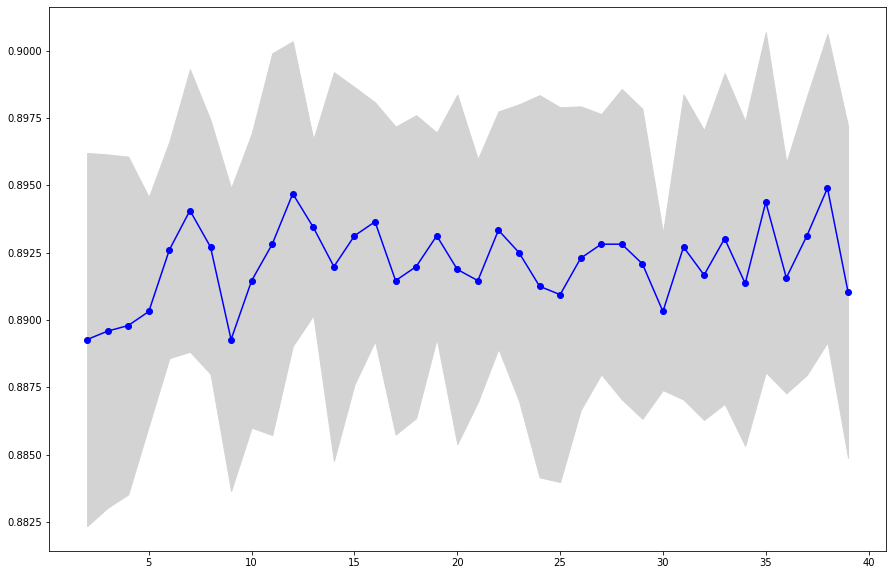

Wall time: 45min 44s


In [30]:
%%time
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                               n_draws=search.best_params_['encoder__n_draws'], 
                               random_state=2834, 
                               prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                               leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                           max_depth=search.best_params_['classifier__max_depth'], 
                           max_features=search.best_params_['classifier__max_features'], 
                           min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                           random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)

param_range = range(2, 40)
search2 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__n_draws' : param_range})

search2.fit(X_train, y_train)
results = search2.cv_results_['mean_test_score']    
    

plt.figure(1, figsize=(15, 10))
plt.plot(list(param_range), results, 'b-o')
plt.fill_between(list(param_range), results - search2.cv_results_['std_test_score'],
                 results + search2.cv_results_['std_test_score'], color='lightgrey')
plt.show();

Seems like the algorithm favors small samples and not large samples, but above 5 the results are statistically the same

Now we will check how the prior distribution affects the accuracy


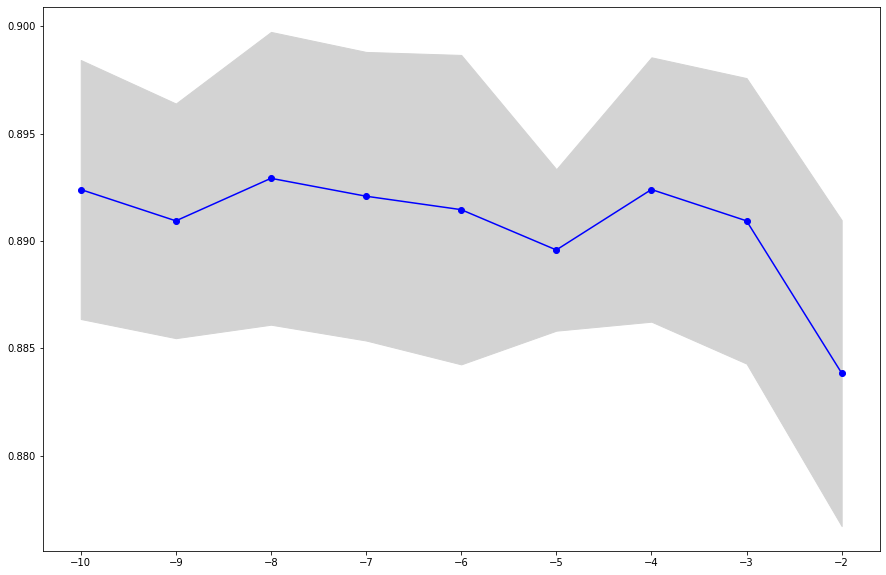

Wall time: 23min 44s


In [31]:
%%time
X_train, X_test, y_train, y_test = train_test_split(predictors.values, y_h, test_size=0.2, random_state=2834)
X_train = pd.DataFrame(X_train, columns=predictors.columns)
X_test = pd.DataFrame(X_test, columns=predictors.columns)

pte = PosteriorImputationEncoderBC(cols=['cat1', 'cat2'], 
                               n_draws=search.best_params_['encoder__n_draws'], 
                               random_state=2834, 
                               prior_samples_ratio=search.best_params_['encoder__prior_samples_ratio'],
                               leave_one_out=search.best_params_['encoder__leave_one_out'])
model = RandomForestClassifier(n_estimators=400, 
                           max_depth=search.best_params_['classifier__max_depth'], 
                           max_features=search.best_params_['classifier__max_features'], 
                           min_samples_leaf=search.best_params_['classifier__min_samples_leaf'], 
                           random_state=2834, n_jobs=-1) 
wrapper_model = EncoderWrapper(pte, model)

param_range =  range(-10, -1)
search3 = GridSearchCV(estimator=wrapper_model, param_grid={'encoder__prior_samples_ratio' : [10**i for i in param_range]})

search3.fit(X_train, y_train)
    
results = search3.cv_results_['mean_test_score']    
    

plt.figure(1, figsize=(15, 10))
plt.plot(list(param_range), results, 'b-o')
plt.fill_between(list(param_range), results - search3.cv_results_['std_test_score'],
                 results + search3.cv_results_['std_test_score'], color='lightgrey')
plt.show();

Seems like the algorithm favors the prior below $10^{-3}$ and within that range the results are not statistically different